In [ ]:
# default_exp normalization

# Normalization
The normalization step of directlfq is adapted from the [MS-EmpiRe algorithm](https://doi.org/10.1074/mcp.RA119.001509). It aims at reducing systematic biases between samples. Such biases can for example occur when more material is pipetted in one of the samples. In principle, two steps are performed:

1. Normalize between samples of the same condition (i.e. replicates)

2. Normalize between different conditions




## Within-condition normalization
It is common practice and highly recommended to measure multiple samples of a given condition. This ensures that observed changes between conditions are not just due to random variation. Examples of samples within the same condition could be biological replicates, but also patients with the same clinical condition. 
We want to ensure that systematic changes between within-condition samples are corrected for as follows:

* Our assumed input values are log2 transformed peptide ion intensities, which are stored in a 2d numpy array called "samples". Each row in samples represents a peptide and each column represents a sample

* In a first step, we determine the all pairwise distances between the samples (details explained below)
* We then choose the pair of samples with the closest distance between each other
* We randomly choose one "anchor" sample and one "shift" sample and we subtract the distance between the samples from each peptide intensity measured in the "shift" sample. This is equivalent to rescaling the intensities of the original sample by a constant factor such that the distributions are aligned
* We then construct a virtual "merged" sample by computing the average intensities of anchor and shift sample
* We repeat the steps above until all samples are merged. Keeping track of the shift factors allows us then to determine an ideal shift for each sample



In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

def get_normfacts_withincond(samples):##row is the sample column is the features

    "finds optimal scaling factors for samples measured in the same condition and corrects the samples by these scaling factors. Takes a 2d numpy array as input  "
    num_samples = samples.shape[0]
    mergedsamples = np.copy(samples) #the virtual "merged" samples will be stored in this array
    sampleidx2shift = dict(zip(range(num_samples), np.zeros(num_samples))) #the scaling factors applied to the samples are stored here
    sampleidx2counts = dict(zip(range(num_samples), np.ones(num_samples)))#keeps track of how many distributions are merged
    sampleidx2anchoridx = {} #keeps track of the shifted samples
    exclusion_set = set() #already clustered samples are stored here
    distance_matrix = create_distance_matrix(samples)
    variance_matrix = create_distance_matrix(samples, metric = 'variance')
    #print(f"distance matrix start\n{distance_matrix}")

    for rep in range(num_samples-1):
        #anchor_idx, shift_idx, min_distance = get_bestmatch_pair(mergedsamples, exclusion_set, sampleidx2counts)
        anchor_idx, shift_idx, min_distance = get_bestmatch_pair(distance_matrix,variance_matrix, sampleidx2counts)
        
        # #determine the closest pair of samples (one "shift" sample to be shifted and one "anchor sample which stays the same") and the distance between this pair
        #update the sets

        if(anchor_idx == None):
            break
        sampleidx2anchoridx.update({shift_idx : anchor_idx})
        sampleidx2shift.update({shift_idx : min_distance })
        exclusion_set.add(shift_idx)

        anchor_sample = mergedsamples[anchor_idx]
        shift_sample = samples[shift_idx]
        shifted_sample = shift_sample + min_distance

        #print(f"\n\nanchor {anchor_sample}\nshift {shift_sample}\nshifted sample{shifted_sample}\nshiftfactor {min_distance}\tsamples {shift_idx}\t{anchor_idx}")
        merged_sample = merge_distribs(anchor_sample, shifted_sample, sampleidx2counts[anchor_idx], sampleidx2counts[shift_idx])
        mergedsamples[anchor_idx] = merged_sample

        #print(f"shift, anchor: {shift_idx}, {anchor_idx} achtual shift {distance_matrix[shift_idx][anchor_idx]} or {distance_matrix[anchor_idx][shift_idx]}")
        #print(f"distance matrix before\n{distance_matrix}")


        update_distance_matrix(variance_matrix, mergedsamples, anchor_idx, shift_idx, metric='variance')
        update_distance_matrix(distance_matrix, mergedsamples, anchor_idx, shift_idx)

        #print(f"distance matrix after\n{distance_matrix}")
        sampleidx2counts[anchor_idx]+=1

    sampleidx2totalshift = {}
    for i in exclusion_set:
        shift = get_total_shift(sampleidx2anchoridx, sampleidx2shift, i)
        sampleidx2totalshift[i] = shift
        #samples[i] = samples[i]+shift
    return sampleidx2totalshift
    #return samples

def apply_sampleshifts(samples, sampleidx2shift):
    for idx in sampleidx2shift.keys():
        samples[idx] = samples[idx] + sampleidx2shift.get(idx)
    return samples

### Find the best matching pair
Take all pairs of the columns in the "samples" array that have not been already merged and compute the distance between the pairs as follows:
* Subtract sample1 from sample2 (or sample2 from sample1, the order does not matter)
* This results in a distribution of differences. As the samples array contains log2 intensities, this corresponds to taking log2 fold changes
* Take the median of the distribution, this is a good approximation for the change between the two distributions
* Select the two samples with the lowest absolute change

In [ ]:
#export
def get_bestmatch_pair(distance_matrix, variance_matrix, sample2counts):
    
    i,j = np.unravel_index(np.argmin(variance_matrix, axis=None), variance_matrix.shape)
    min_distance = distance_matrix[i,j]
    #print(f"idxs are {i}, {j} median is {distance_matrix[i][j]} variance is {variance_matrix[i][j]}")
    if(min_distance == np.inf):
        return None, None, None
    anchor_idx, shift_idx, min_distance = determine_anchor_and_shift_sample(sample2counts,i, j, min_distance) #direction flip of distance if necessary
    return anchor_idx, shift_idx, min_distance


In [ ]:
#export
def create_distance_matrix(samples, metric = 'median'):
    num_samples = samples.shape[0]
    distance_matrix = np.full((num_samples, num_samples), np.inf)
    for i in range(num_samples):
        for j in range(i+1, num_samples):#do every comparison once
            distance_matrix[i,j] = calc_distance(metric, samples[i], samples[j]) #the median of the shifted distribution is taken as the distance measure
            
    return distance_matrix


In [ ]:
#export
def calc_distance(metric, samples_1, samples_2):
    res = None

    if metric == 'median':
        res = np.nanmedian(get_fcdistrib(samples_1, samples_2))#the median of the shifted distribution is taken as the distance measure
    if(metric == 'variance'):
        fcdist = get_fcdistrib(samples_1, samples_2)
        #if sum(~np.isnan(fcdist))<2:
         #   return np.nan
        res = np.nanvar(fcdist)
    if res == None:
        raise Exception(f"distance metric {metric} not implemented")
    if(np.isnan(res)):
        return np.inf
    else:
        return res

In [ ]:
#export
def update_distance_matrix(distance_matrix, merged_samples, merged_sample_idx, shift_idx,metric ='median'):
    "determine the distances to the newly merged sample"
    for i in range(0, merged_sample_idx):#update rows of distance matrix
        if distance_matrix[i, merged_sample_idx]==np.inf:#do not compare already merged samples
            continue
        distance = calc_distance(metric,merged_samples[i], merged_samples[merged_sample_idx])
        distance_matrix[i, merged_sample_idx] = distance
    
    for j in range(merged_sample_idx+1, merged_samples.shape[0]):#update columns of distance matrix
        if distance_matrix[merged_sample_idx, j] == np.inf:
            continue
        distance = calc_distance(metric,merged_samples[merged_sample_idx], merged_samples[j])
        distance_matrix[merged_sample_idx, j] = distance
    
    distance_matrix[shift_idx] = np.inf #shifted samples are excluded by setting distance to infinity
    distance_matrix[:, shift_idx] = np.inf
        

In [ ]:
#export
def get_fcdistrib(logvals_rep1, logvals_rep2):
    "generates difference distribution between two samples"
    dist = np.subtract(logvals_rep1, logvals_rep2)
    return dist

In [ ]:
#export
def determine_anchor_and_shift_sample(sample2counts, i_min, j_min, min_distance):
    "given two samples, declare the sample with fewer merges as the shift"
    counts_i = sample2counts[i_min]
    counts_j = sample2counts[j_min]
    anchor_idx = i_min if counts_i>=counts_j else j_min
    shift_idx = j_min if anchor_idx == i_min else i_min
    flip = 1 if anchor_idx == i_min else -1
    return anchor_idx, shift_idx, flip*min_distance

### Shifting samples
When we have computed the distance between two samples, we want to correct one of the samples by this distance. This results in two distributions with the same median value. We always shift the sample which has been merged from fewer distributions (see below for details). The sample to which the shift is applied is call "shift" sample and the sample which is not shifted is called "anchor" sample.
A "total shift" is calculated after all samples are merged, just by following up how many shifts have been applied to a sample in total

In [ ]:
#export
def shift_samples(samples, sampleidx2anchoridx, sample2shift):
    for sample_idx in range(samples.shape[0]):
        samples[sample_idx] = samples[sample_idx]+get_total_shift(sampleidx2anchoridx, sample2shift, sample_idx)

In [ ]:
#export
def get_total_shift(sampleidx2anchoridx, sample2shift,sample_idx):

    total_shift = 0.0

    while(True):
        total_shift +=sample2shift[sample_idx]
        if sample_idx not in sampleidx2anchoridx: #every shifted sample has an anchor
            break
        sample_idx = sampleidx2anchoridx[sample_idx]

    return total_shift

### Merging distributions
After we shift two distributions on top of each other, we calculate a "merged" distribution. Each intensity in the merged distribution is the average of the intensity in both distributions. For the merging we have to take into account the following: If for example the anchor sample has already been merged from 10 samples, and the shift distribution has not been merged at all, we want to weigh the distribution coming from many samples higher. We hence multiply each sample by the number of merges.

In [ ]:
#export
import time
import numpy as np

def merge_distribs(anchor_distrib, shifted_distrib,counts_anchor_distrib, counts_shifted_distrib):
    "Calculate the average peptide intensities to merge two peptide distributions"

    t_alt = time.time()
    res = np.zeros(len(anchor_distrib))

    nans_anchor = np.isnan(anchor_distrib)
    nans_shifted = np.isnan(shifted_distrib)
    nans_anchor_and_shifted = nans_anchor & nans_shifted
    nans_only_anchor = nans_anchor & ~nans_shifted
    nans_only_shifted = nans_shifted &~nans_anchor
    no_nans = ~nans_anchor & ~nans_shifted

    idx_anchor_and_shifted = np.where(nans_anchor_and_shifted)
    idx_only_anchor = np.where(nans_only_anchor)
    idx_only_shifted = np.where(nans_only_shifted)
    idx_no_nans = np.where(no_nans)

    res[idx_anchor_and_shifted] = np.nan
    res[idx_only_anchor] = shifted_distrib[idx_only_anchor]
    res[idx_only_shifted] = anchor_distrib[idx_only_shifted]
    res[idx_no_nans] = (anchor_distrib[idx_no_nans] *counts_anchor_distrib + shifted_distrib[idx_no_nans]*counts_shifted_distrib)/(counts_anchor_distrib+counts_shifted_distrib)
    return res

## Compare Distributions

In [ ]:
#export
import scipy.stats
def determine_mode_iteratively(fcs):
    
    fcs = np.sort(fcs)
    #cut away the most extreme fold changes
    cumul_counts = np.linspace(0, len(fcs), len(fcs))
    cumul_counts_rel = cumul_counts/cumul_counts[-1]
    thresh = 0.05
    subset_vec = (cumul_counts_rel>thresh/2) & (cumul_counts_rel<1-thresh/2)
    fcs_subset = fcs[subset_vec]

    window_size = (max(fcs_subset) - min(fcs_subset))/2

    while len(fcs_subset)> 40:
        new_fc_range = []
        maximum_fcs = -1
        i=0
        while i<= (len(fcs_subset) - window_size): #sliding window through the fold changes
            fc_lower = fcs_subset[i]
            fc_upper = fc_lower + window_size
            fc_upper_idx = find_nearest(fcs_subset, fc_upper)
            number_fcs_in_interval = fc_upper_idx - i
            if number_fcs_in_interval > maximum_fcs:
                maximum_fcs = number_fcs_in_interval
                new_fc_range = [i, fc_upper_idx]
            i+=1
        fcs_subset = fcs_subset[new_fc_range[0]:new_fc_range[1]]
        window_size = window_size/2
    #fc_selected = scipy.stats.mode(fcs_subset).mode[0]
    fc_selected = np.median(fcs_subset)
    return fc_selected


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx




In [ ]:
#export
import numpy as np
from scipy.signal import find_peaks
import pandas as pd

def mode_normalization(x):

    x = np.sort(x)
    
    #cut away the most extreme fold changes
    cumul_counts = np.linspace(0, len(x), len(x))
    cumul_counts_rel = cumul_counts/cumul_counts[-1]
    thresh = 0.05
    subset_vec = (cumul_counts_rel>thresh/2) & (cumul_counts_rel<1-thresh/2)
    x = x[subset_vec]

    x_min = min(x)
    x_max = max(x)
    num_bins = int((x_max-x_min)*50)
    bins = np.linspace(x_min, x_max, num_bins)
    hist = np.histogram(x, bins)
    x = hist[0]
    fcs =  0.5*(hist[1][1:]+hist[1][:-1]) #get middle of each fc bin
    cumul_x = np.cumsum(x)

    peaks2  = find_peaks(x, prominence=1)
    lbase = peaks2[1]['left_bases']
    rbase = peaks2[1]['right_bases']
    cumul_heights = cumul_x[rbase] - cumul_x[lbase]
    max_cumul_idx = np.argmax(cumul_heights)#returns the peak with the highest probabilty mass
    max_idx = peaks2[0][max_cumul_idx]
    shift_fc = hist[1][max_idx]

    return shift_fc

In [ ]:
#export
import numpy as np
from scipy import stats

def get_betweencond_shift(df_c1_normed, df_c2_normed, enfore_median = False):

    both_idx = df_c1_normed.index.intersection(df_c2_normed.index)
    df1 = df_c1_normed.loc[both_idx]
    df2 = df_c2_normed.loc[both_idx]
    df1 = df1.median(axis = 1, skipna = True).to_frame()
    df2 = df2.median(axis = 1, skipna = True).to_frame()
    col1 = df1.columns[0]
    col2 = df2.columns[0]

    diff_fcs = df1[col1].to_numpy() - df2[col2].to_numpy()
    median = np.nanmedian(diff_fcs)
    if enfore_median:
        return -median
        
    if len(diff_fcs)<100:
        print("using median for shift")
        return -median
    mode = mode_normalization(diff_fcs)
    #mode = determine_mode_iteratively(diff_fcs)
    print(f"median {median}, mode {mode}")
    if(abs(median-mode) <0.05):
        print(f"using median for shift")
        return -median
    else:
        print(f"using mode for shift")
        return -mode

## Wrapper functions

In [ ]:
#export
import pandas as pd
import directlfq.visualizations as aqviz
def normalize_if_specified(df_c1, df_c2, c1_samples, c2_samples, minrep, normalize_within_conds = True, normalize_between_conds = True, runtime_plots = True, protein_subset_for_normalization_file = None, pep2prot =None,prenormed_file = None): #labelmap_df, unnormed_df,condpair,


    if prenormed_file is not None:
        return use_benchmark_prenormed_file(prenormed_file=prenormed_file, minrep = minrep, c1_samples = c1_samples, c2_samples = c2_samples)


    if normalize_within_conds:
        df_c1 = normalize_within_cond(df_c=df_c1, samples_c= c1_samples)
        df_c2 = normalize_within_cond(df_c=df_c2, samples_c=c2_samples)
        print(f"normalized within conditions")
    
    if runtime_plots:
        plot_withincond_normalization(df_c1, df_c2)
    
    if normalize_between_conds:
        df_c1, df_c2 = get_normalized_dfs_between_conditions(df_c1, df_c2, protein_subset_for_normalization_file, pep2prot,runtime_plots = runtime_plots)
        print("normalized between conditions")
    
    return df_c1, df_c2



def get_normalized_dfs_between_conditions(df_c1, df_c2, protein_subset_for_normalization_file, pep2prot,runtime_plots):
    shift_between_cond = prepare_tables_and_get_betweencond_shift(df_c1, df_c2, protein_subset_for_normalization_file, pep2prot)

    print(f"shift comparison by {shift_between_cond}")
    df_c2 = df_c2-shift_between_cond
    #compare_normalization("./test_data/normed_intensities.tsv", df_c1_normed, df_c2_normed)
    if runtime_plots:
        aqviz.plot_betweencond_fcs(df_c1, df_c2, False)
        aqviz.plot_betweencond_fcs(df_c1, df_c2, True)
    return df_c1, df_c2

def normalize_within_cond(df_c, samples_c):
    sample2shift = get_normfacts_withincond(drop_nas_if_possible(df_c).to_numpy().T)
    df_c_normed = pd.DataFrame(apply_sampleshifts(df_c.to_numpy().T, sample2shift).T, index = df_c.index, columns = samples_c)
    return df_c_normed

def prepare_tables_and_get_betweencond_shift(df_c1, df_c2, protein_subset_for_normalization_file, pep2prot):
    specified_protein_subset = read_specified_protein_subset_if_given(protein_subset_for_normalization_file)
    prepared1 = prepare_table_for_betweencond_shift(df_c1, specified_protein_subset, pep2prot)
    prepared2 = prepare_table_for_betweencond_shift(df_c2, specified_protein_subset, pep2prot)
    enforce_median = protein_subset_for_normalization_file is not None
    return get_betweencond_shift(prepared1, prepared2, enforce_median)

def read_specified_protein_subset_if_given(specified_protein_subset_file):
    if specified_protein_subset_file is not None:
        return get_protein_subset_from_protein_list(pd.read_csv(specified_protein_subset_file, sep = "\t")["protein"])
    else:
        return None

def get_protein_subset_from_protein_list(protein_list):
    protein_subset = []
    for proteingroup in protein_list:
        for protein in proteingroup.split(";"):
            protein_subset.append(protein)
    
    return set(protein_subset)


def prepare_table_for_betweencond_shift(df, specified_protein_subset, pep2prot):
    filtered_df = filter_to_protein_subset(df, specified_protein_subset, pep2prot)
    filtered_df = drop_nas_if_possible(filtered_df)
    return filtered_df
    

def filter_to_protein_subset(df, specified_protein_subset, pep2prot):
    if specified_protein_subset is None:
        return df
    else:
        proteins = [pep2prot.get(x) for x in df.index]
        return df[[test_if_proteingroup_is_in_subset(x, specified_protein_subset) for x in proteins]] #protein is set to index

def test_if_proteingroup_is_in_subset(proteingroup, specified_protein_subset):
    for protein in proteingroup.split(";"):
        if protein in specified_protein_subset:
            return True
    
    return False


def drop_nas_if_possible(df):
    df_nonans = df.dropna(axis=0)
    fraction_nonans = calculate_fraction_with_no_NAs(df, df_nonans)
    if fraction_nonans<0.05:
        print('to few values for normalization without missing values. Including missing values')
        return df
    else:
        return df_nonans

def calculate_fraction_with_no_NAs(df, df_nonnans):
    return len(df_nonnans.index)/len(df.index)


def plot_withincond_normalization(df_c1, df_c2):
    print("without missingvals (if applicable)")
    aqviz.plot_betweencond_fcs(drop_nas_if_possible(df_c1), drop_nas_if_possible(df_c2), True)
    print("complete dataset")
    aqviz.plot_betweencond_fcs(df_c1, df_c2, True)

def use_benchmark_prenormed_file(prenormed_file, minrep, c1_samples, c2_samples):
    print("using pre-normalized data - skipping normalization")
    df_prenormed = pd.read_csv(prenormed_file, sep="\t",index_col = "ion")
    df_c1_normed = df_prenormed[c1_samples].dropna(thresh=minrep, axis=0)
    df_c2_normed = df_prenormed[c2_samples].dropna(thresh=minrep, axis=0)
    df_c2_normed = df_c2_normed +0.18
    return df_c1_normed, df_c2_normed

## Unit tests

In [ ]:
#hide
def test_merged_distribs():
    anchor_distrib = np.array([1, 1, 1, 1, 1])
    shift_distrib = np.array([2, 2, 2, 2, 2])
    counts_anchor_distrib = 4
    counts_shifted_distib = 1
    assert (merge_distribs(anchor_distrib, shift_distrib, counts_anchor_distrib, counts_shifted_distib)== np.array([1.2, 1.2, 1.2, 1.2, 1.2])).any()

test_merged_distribs() 

In [ ]:
#hide
def generate_randarrays(number_arrays,size_of_array):
    randarray = []
    for i in range(number_arrays):
        shift = np.random.uniform(low=-10, high=+10)
        randarray.append(np.random.normal(loc=shift, size=size_of_array))
    return np.array(randarray)


STDev 1.0076066494260316


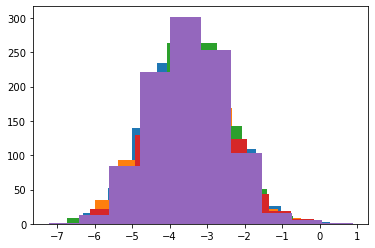

In [ ]:
#hide
import numpy as np
import matplotlib.pyplot as plt

def test_sampleshift(samples):
    num_samples = samples.shape[0]
    merged_sample = []
    for i in range(num_samples):
        plt.hist(samples[i])
        merged_sample.extend(samples[i])
    stdev = np.std(merged_sample)
    print(f"STDev {stdev}")
    assert (stdev <=1.2) 
    
    plt.show()

randarray = generate_randarrays(5, 1000)
sample2shift = get_normfacts_withincond(randarray)
normalized_randarray = apply_sampleshifts(randarray, sample2shift)
test_sampleshift(normalized_randarray)